## Libraries

In [112]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid")

## Functions

## Analysis Plan

### Steps to solve and answer the homeworks:

## Main Homework

## 1. Propensity Score Matching

Read data from the provided dataset

In [130]:
dataset_file = 'lalonde.csv'
df_combined  = pd.read_csv(dataset_file)

df_combined.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1a. Naive Analysis

* First, we split data into two groups, treatment and control, based on treatment on subject or not (treat 1 or 0)
* We quickly figure out that zeros are presence in re78 column. We can assume that zeros in earnings column are either no data or each correspond subject actually did not has earnings at all in 1978. 
* Thus we take into account and we create dataframes with zeros replaces with NaN. By doing this, we can count only mean of the non-zeros values.

In [88]:
def split_data(dataframe):
    return df.loc[df["treat"]==1], df.loc[df["treat"]==0]

df_treated, df_control = split_data(df_combined)
df_treated_with_nan    = df_treated.replace(0,np.NAN)
df_control_with_nan    = df_control.replace(0,np.NAN)

A naive closer look into the data of treatment group

In [77]:
# we don't want to account for zero, thus we show the dataframe with NaN
print("Statistics of Treated Group")
display(df_treated_with_nan.describe()[['re78']])

Statistics of Treated Group


,re78
count,140.000000
mean,8389.939665
std,8042.944693
min,289.789900
25%,3167.353750
50%,6504.144500
75%,11017.730000
max,60307.930000


A naive closer look into the data of control group

In [76]:
# we don't want to account for zero, thus we show the dataframe with NaN
print("Statistics of Control Group")
display(df_control_with_nan.describe()[['re78']])

Statistics of Control Group


,re78
count,331.000000
mean,9051.990391
std,7087.340468
min,31.032260
25%,2978.358000
50%,7310.313000
75%,14131.500000
max,25564.670000


#### Naive plots - Include Zeros in re78

Mean earning of Treated group:  6349.143530270269
Median earning of Treated group:  4232.309
Mean earning of Control group:  6984.169742307697
Median earning of Control group:  4975.505


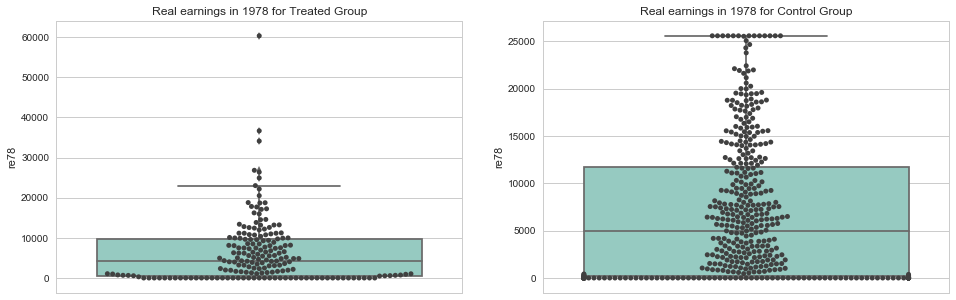

In [113]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 5)
ax1 = sns.boxplot(y = 're78' , data=df_treated, ax = ax1, palette="Set3")
ax1 = sns.swarmplot(y = 're78' , data=df_treated, ax = ax1, color=".25")
ax1.set_title("Real earnings in 1978 for Treated Group")

ax2 = sns.boxplot(y = 're78' , data=df_control, ax = ax2, palette="Set3")
ax2 = sns.swarmplot(y = 're78' , data=df_control, ax = ax2, color=".25")
ax2.set_title("Real earnings in 1978 for Control Group")

print("Mean earning of Treated group: ",df_treated['re78'].mean())
print("Median earning of Treated group: ",df_treated['re78'].median())
print("Mean earning of Control group: ",df_control['re78'].mean())
print("Median earning of Control group: ",df_control['re78'].median())

#### Naive plots - Exclude Zeros in re78 and outliers

Average earning of Treated group (zeros excluded):  8389.939665
Median earning of Treated group (zeros excluded):  6504.144499999999
Average earning of Control group (zeros excluded):  9051.990391087618
Median earning of Control group (zeros excluded):  7310.313


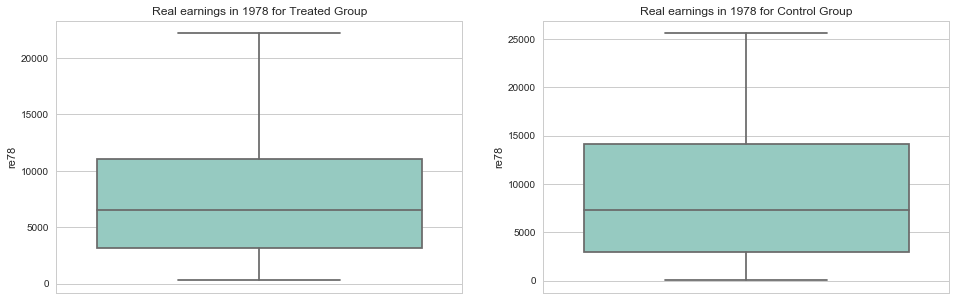

In [114]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 5)
ax1 = sns.boxplot(y = 're78' , data=df_treated_with_nan, ax = ax1, palette="Set3", showfliers=False)
ax1.set_title("Real earnings in 1978 for Treated Group")

ax2 = sns.boxplot(y = 're78' , data=df_control_with_nan, ax = ax2, palette="Set3", showfliers=False)
ax2.set_title("Real earnings in 1978 for Control Group")

print("Average earning of Treated group (zeros excluded): ",df_treated_with_nan['re78'].mean())
print("Median earning of Treated group (zeros excluded): ",df_treated_with_nan['re78'].median())
print("Average earning of Control group (zeros excluded): ",df_control_with_nan['re78'].mean())
print("Median earning of Control group (zeros excluded): ",df_control_with_nan['re78'].median())

#### Naive plots - Treat vs Re78 in General

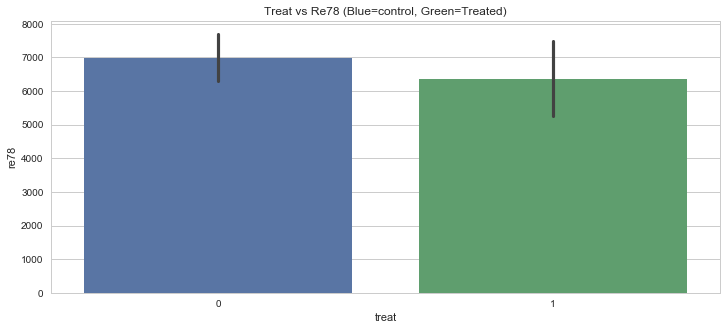

In [116]:
fig, ax = plt.subplots(ncols=1, sharey=True)
fig.set_size_inches(12, 5)
ax = sns.barplot(x="treat", y="re78", data=df_combined.sort_values(["treat"],ascending=True))
ax.set_title("Treat vs Re78 (Blue=control, Green=Treated)")

#### Observing outliers in treated group

In [65]:
df_treated.loc[df['re78'] > 20000]

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
2,NSW3,1,30,12,1,0,0,0,0.000,0.0000,24909.45
35,NSW36,1,42,14,1,0,0,0,0.000,0.0000,20505.93
78,NSW79,1,40,11,1,0,0,1,0.000,0.0000,23005.60
99,NSW100,1,31,9,0,1,0,1,0.000,0.0000,26817.60
106,NSW107,1,27,13,1,0,0,0,0.000,0.0000,34099.28
116,NSW117,1,27,12,1,0,0,0,2143.413,357.9499,22163.25
131,NSW132,1,28,11,1,0,0,1,0.000,1284.0790,60307.93
148,NSW149,1,26,11,1,0,1,1,0.000,2754.6460,26372.28
181,NSW182,1,25,14,1,0,1,0,35040.070,11536.5700,36646.95


### Naive observations

We observe that:
1. There is no impact of job training program to subject's earning as outcome (re78) of treated group tends to be lower even in median (which is sensitive to outliers)
2. The training is effective only to several subjects whom we can see as outliers in treated group.

### 1b. A Closer Look Into the Data

In [148]:
n_treated = df_combined.loc[df_combined["treat"]==1].shape[0]
n_control = df_combined.loc[df_combined["treat"]==0].shape[0]

print("Number of Treated Subject: ",n_treated)
print("Number of Control Subject: ",n_control)

Number of Treated Subject:  185
Number of Control Subject:  429


### Discrete Features (black, hispan, married, nodegree)

In [133]:
df_black    = df_combined.loc[df_combined["black"]==1]
df_hispan   = df_combined.loc[df_combined["hispan"]==1]
df_married  = df_combined.loc[df_combined["married"]==1]
df_nodegree = df_combined.loc[df_combined["nodegree"]==1]

In [151]:
n_black_treated    = df_black.loc[df_black["treat"]==1].shape[0]
n_black_control    = df_black.loc[df_black["treat"]==0].shape[0]

n_hispan_treated   = df_hispan.loc[df_hispan["treat"]==1].shape[0]
n_hispan_control   = df_hispan.loc[df_hispan["treat"]==0].shape[0]

n_married_treated  = df_married.loc[df_married["treat"]==1].shape[0]
n_married_control  = df_married.loc[df_married["treat"]==0].shape[0]

n_nodegree_treated = df_nodegree.loc[df_nodegree["treat"]==1].shape[0]
n_nodegree_control = df_nodegree.loc[df_nodegree["treat"]==0].shape[0]

Number of Black Subject in Treated Group:  156
Number of Black Subject in Control Group:  87
Number of Hispan Subject in Treated Group:  11
Number of Hispan Subject in Control Group:  61
Number of Married Subject in Treated Group:  35
Number of Married Subject in Control Group:  220
Number of Nodegree Subject in Treated Group:  131
Number of Nodegree Subject in Control Group:  256


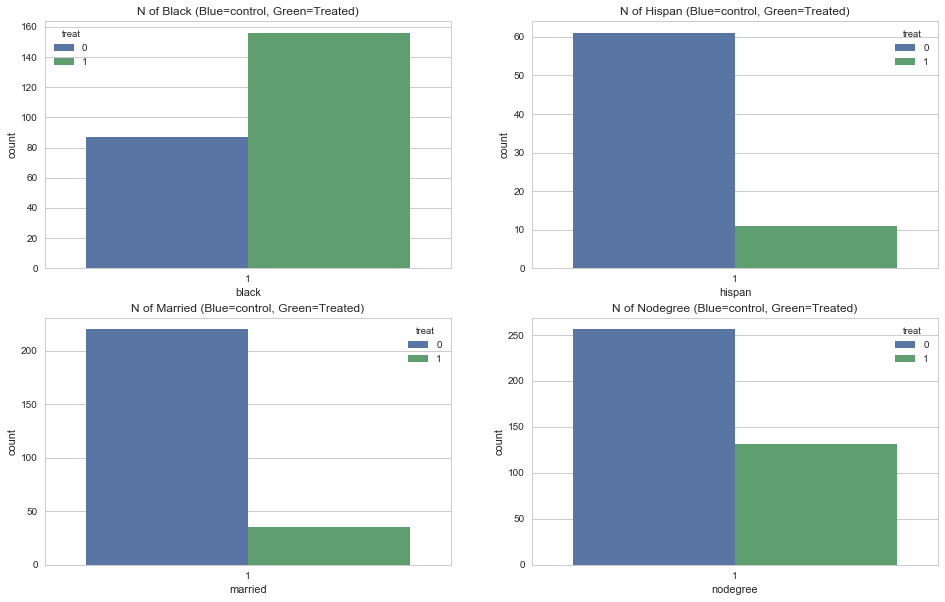

In [150]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 10)
ax1 = sns.countplot(x="black", hue="treat", ax=ax1, data=df_black)
ax1.set_title("N of Black (Blue=control, Green=Treated)")

ax2 = sns.countplot(x="hispan", hue="treat", ax=ax2, data=df_hispan)
ax2.set_title("N of Hispan (Blue=control, Green=Treated)")

ax3 = sns.countplot(x="married", hue="treat", ax=ax3, data=df_married)
ax3.set_title("N of Married (Blue=control, Green=Treated)")

ax4 = sns.countplot(x="nodegree", hue="treat", ax=ax4, data=df_nodegree)
ax4.set_title("N of Nodegree (Blue=control, Green=Treated)")

print("Number of Black Subject in Treated Group: ",n_black_treated)
print("Number of Black Subject in Control Group: ",n_black_control)

print("Number of Hispan Subject in Treated Group: ",n_hispan_treated)
print("Number of Hispan Subject in Control Group: ",n_hispan_control)

print("Number of Married Subject in Treated Group: ",n_married_treated)
print("Number of Married Subject in Control Group: ",n_married_control)

print("Number of Nodegree Subject in Treated Group: ",n_nodegree_treated)
print("Number of Nodegree Subject in Control Group: ",n_nodegree_control)

To view the features in same scale, we calculate the percentage of each binary feature

In [170]:
pr_black_treated    = n_black_treated / n_treated
pr_black_control    = n_black_control / n_control

pr_hispan_treated   = n_hispan_treated / n_treated
pr_hispan_control   = n_hispan_control / n_control

pr_married_treated  = n_married_treated / n_treated
pr_married_control  = n_married_control / n_control

pr_nodegree_treated = n_nodegree_treated / n_treated
pr_nodegree_control = n_nodegree_control / n_control

In [171]:
data = {
        'features':['black','hispan','married','nodegree'],
        'pr_treated':[pr_black_treated, pr_hispan_treated, pr_married_treated, pr_nodegree_treated],
        'pr_control':[pr_black_control, pr_hispan_control, pr_married_control, pr_nodegree_control]
       }

df_temp = (pd.DataFrame(data, columns = ['features', 'pr_treated', 'pr_control']))
df_temp

,features,pr_treated,pr_control
0,black,0.843243,0.202797
1,hispan,0.059459,0.142191
2,married,0.189189,0.512821
3,nodegree,0.708108,0.596737


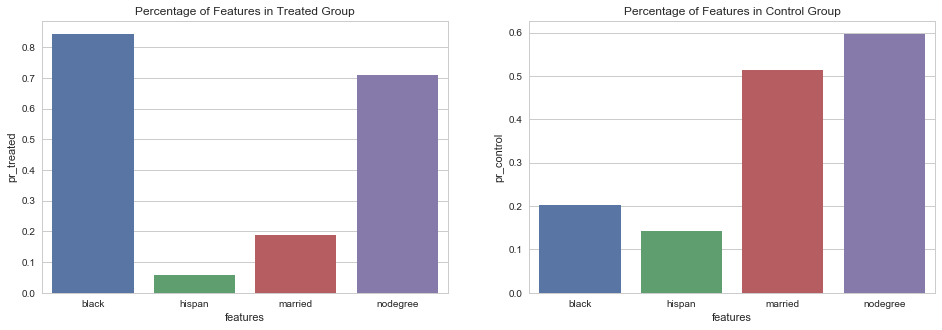

In [172]:
fig, ([ax1, ax2]) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 5)
ax1 = sns.barplot(x="features", y="pr_treated", ax=ax1, data=df_temp)
ax1.set_title("Percentage of Features in Treated Group")

ax2 = sns.barplot(x="features", y="pr_control", ax=ax2, data=df_temp)
ax2.set_title("Percentage of Features in Control Group")

### Continous Features (age, educ, re74, re75)

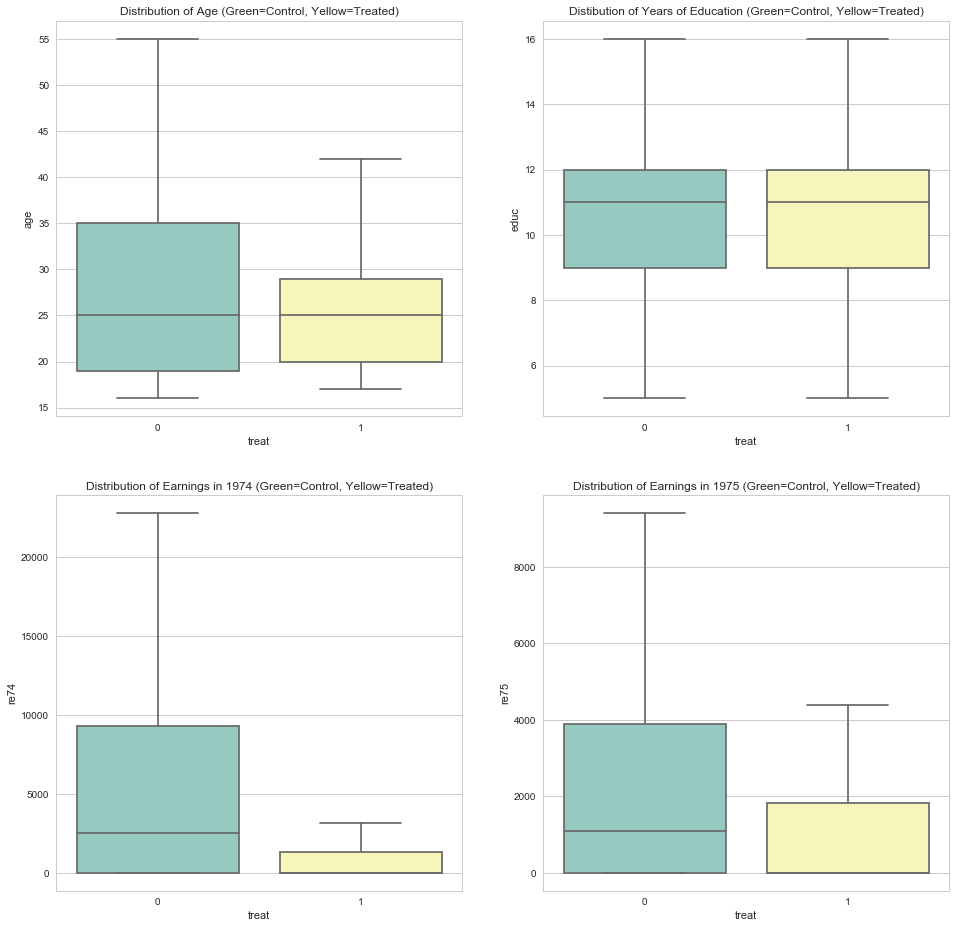

In [144]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 16)
ax1 = sns.boxplot(y="age", x="treat", ax=ax1, data=df_combined, palette="Set3", showfliers=False)
ax1.set_title("Distribution of Age (Green=Control, Yellow=Treated)")

ax2 = sns.boxplot(y="educ", x="treat", ax=ax2, data=df_combined, palette="Set3", showfliers=False)
ax2.set_title("Distibution of Years of Education (Green=Control, Yellow=Treated)")

ax3 = sns.boxplot(y="re74", x="treat", ax=ax3, data=df_combined, palette="Set3", showfliers=False)
ax3.set_title("Distribution of Earnings in 1974 (Green=Control, Yellow=Treated)")

ax4 = sns.boxplot(y="re75", x="treat", ax=ax4, data=df_combined, palette="Set3", showfliers=False)
ax4.set_title("Distribution of Earnings in 1975 (Green=Control, Yellow=Treated)")